In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import configparser
import seaborn as sns
import pandas as pd

In [4]:
# covariates variance explained
def parse_cv_results(cv_results: str):
    parsed = ("".join(c for c in cv_results if (c.isdigit() or c == " " or c == "."))).split()
    parsed = [max(float(e), 0) for e in parsed]
    return parsed

In [5]:
def plot_perf_comparison_ax2(ax, lasso_label:str, rf_labels:list, xgb_labels:list, analyse_type:str, is_test:str, r2=True, set_bugged_text=False):
    config_pfac = configparser.ConfigParser()
    config_pfac.read('./p-factor/results.ini')
    config_mets = configparser.ConfigParser()
    config_mets.read('./mets/results.ini')
    config_lung = configparser.ConfigParser()
    config_lung.read('./lung_function/results.ini')
    labels = ['p-factor', 'mets score', 'lung function (FEV1)']

    lasso = [parse_cv_results(config_pfac[analyse_type][lasso_label])[0],
             parse_cv_results(config_mets[analyse_type][lasso_label])[0],
             parse_cv_results(config_lung[analyse_type][lasso_label])[0]]
    lasso_std = [parse_cv_results(config_pfac[analyse_type][lasso_label])[1],
             parse_cv_results(config_mets[analyse_type][lasso_label])[1],
             parse_cv_results(config_lung[analyse_type][lasso_label])[1]]
    
    rf = [parse_cv_results(config_pfac[analyse_type][rf_labels[0]])[0],
          parse_cv_results(config_mets[analyse_type][rf_labels[0]])[0],
          parse_cv_results(config_lung[analyse_type][rf_labels[0]])[0]]
    rf_std = [parse_cv_results(config_pfac[analyse_type][rf_labels[0]])[1],
              parse_cv_results(config_mets[analyse_type][rf_labels[0]])[1],
              parse_cv_results(config_lung[analyse_type][rf_labels[0]])[1]]
    
    xgb = [parse_cv_results(config_pfac[analyse_type][xgb_labels[0]])[0],
           parse_cv_results(config_mets[analyse_type][xgb_labels[0]])[0],
           parse_cv_results(config_lung[analyse_type][xgb_labels[0]])[0]]
    xgb_std = [parse_cv_results(config_pfac[analyse_type][xgb_labels[0]])[1],
               parse_cv_results(config_mets[analyse_type][xgb_labels[0]])[1],
               parse_cv_results(config_lung[analyse_type][xgb_labels[0]])[1]]
    
    if len(rf_labels) > 1:
        rf_fs = [parse_cv_results(config_pfac[analyse_type][rf_labels[1]])[0],
                 parse_cv_results(config_mets[analyse_type][rf_labels[1]])[0],
                 parse_cv_results(config_lung[analyse_type][rf_labels[1]])[0]]
        rf_fs_std = [parse_cv_results(config_pfac[analyse_type][rf_labels[1]])[1],
                 parse_cv_results(config_mets[analyse_type][rf_labels[1]])[1],
                 parse_cv_results(config_lung[analyse_type][rf_labels[1]])[1]]
        if r2:
            rf_diff = (np.array(rf_fs) - np.array(rf))
        else:
            rf_diff = (np.array(rf_fs) - np.array(rf))
    if len(xgb_labels) > 1:
        xgb_fs = [parse_cv_results(config_pfac[analyse_type][xgb_labels[1]])[0],
                  parse_cv_results(config_mets[analyse_type][xgb_labels[1]])[0],
                  parse_cv_results(config_lung[analyse_type][xgb_labels[1]])[0]]
        xgb_fs_std = [parse_cv_results(config_pfac[analyse_type][xgb_labels[1]])[1],
                      parse_cv_results(config_mets[analyse_type][xgb_labels[1]])[1],
                      parse_cv_results(config_lung[analyse_type][xgb_labels[1]])[1]]
        if r2:
            xgb_diff = np.array(xgb_fs) - np.array(xgb)
        else:
            xgb_diff = np.array(xgb_fs) - np.array(xgb)
        
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    # stacks
    rects1 = ax.bar(x - width, lasso, width, label='lasso', hatch='//', color='white', edgecolor='#21914F', alpha=0.7, linewidth=1, yerr=lasso_std, capsize=2, ecolor='black', error_kw={'elinewidth': 0.8})
    rects2 = ax.bar(x, rf, width, label='random forest', capsize=2, ecolor='black', error_kw={'elinewidth': 0.8}, yerr=rf_std)
    rects3 = ax.bar(x + width, xgb, width, label='xgboost', capsize=2, ecolor='black', error_kw={'elinewidth': 0.8}, yerr=xgb_std)
    
    l = []
    for i in range(len(rf)):
        l.append("{0:.2f}+/-{1:.2f}".format(rf[i], rf_std[i]))
    ax.bar_label(rects2, padding=1, labels=l, fontsize=9)
    l = []
    for i in range(len(xgb)):
        l.append("{0:.2f}+/-{1:.2f}".format(xgb[i], xgb_std[i]))
    ax.bar_label(rects3, padding=1, labels=l, fontsize=9)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if is_test:
        mode="test"
    else:
        mode="train"
    if r2:
        ax.set_ylabel(f"Scores ({mode} r2)")
        ax.set_ylim([0, 1])
        metric = "R2"
    else:
        ax.set_ylabel(f"Scores ({mode} rmse)")
        ax.set_ylim([0, 2])
        metric="RMSE"
        
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(labelbottom=True)
    ax.legend()

    # labels=[f'{x:.2f}' for x in container.datavalues]
    # ax.bar_label(rects1, padding=0, fmt='%.2f')
    
    l = []
    for i in range(len(lasso)):
        l.append("{0:.2f}+/-{1:.2f}".format(lasso[i], lasso_std[i]))
    ax.bar_label(rects1, padding=1, labels=l, fontsize=9)

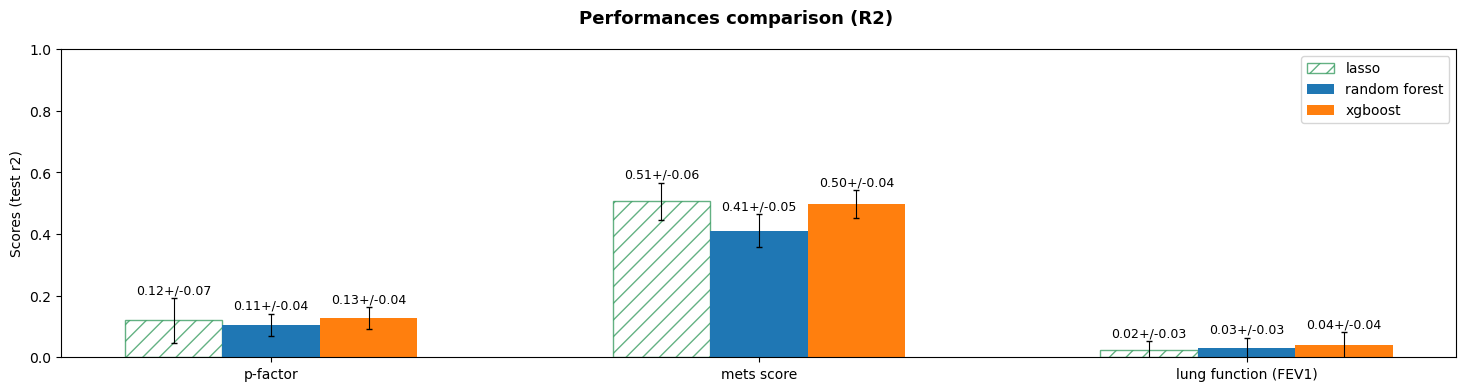

In [6]:
analyse_type='2STEPS'
is_test=True
lasso_labels = ['step1_linearregression_cv_test_R2', 'step2_lasso_cv_all_test_r2', 'final_lasso_cv_all_test_r2']
rf_labels = ['step1_randomforestregressor_cv_test_r2', 'step2_randomforestregressor_cv_all_test_r2', 'final_randomforestregressor_cv_all_test_r2']
xgb_labels = ['step1_xgbregressor_cv_test_r2', 'step2_xgbregressor_cv_all_test_r2', 'final_xgbregressor_cv_all_test_r2']
# rf_fs_labels = ['step2_randomforestregressor_cv_fs_test_r2', 'final_randomforestregressor_cv_fs_test_r2']
# xgb_fs_labels = ['step2_xgbregressor_cv_fs_test_r2', 'final_xgbregressor_cv_fs_test_r2']

fig, ax2 = plt.subplots(1, 1, figsize=(18, 4))
fig.suptitle("Performances comparison (R2)", fontsize=13, fontweight='bold')
plot_perf_comparison_ax2(ax2, lasso_label=lasso_labels[1],
                        rf_labels=[rf_labels[1]],
                        xgb_labels= [xgb_labels[1]],
                        analyse_type='2STEPS',
                        is_test=True, set_bugged_text=True)
# ax2.set_title(f"Step two: residuals' variance explained by other variables", fontsize=11)
# fig.tight_layout()
fig.savefig('./../../data/results/images/perfs_small.png')
plt.show()

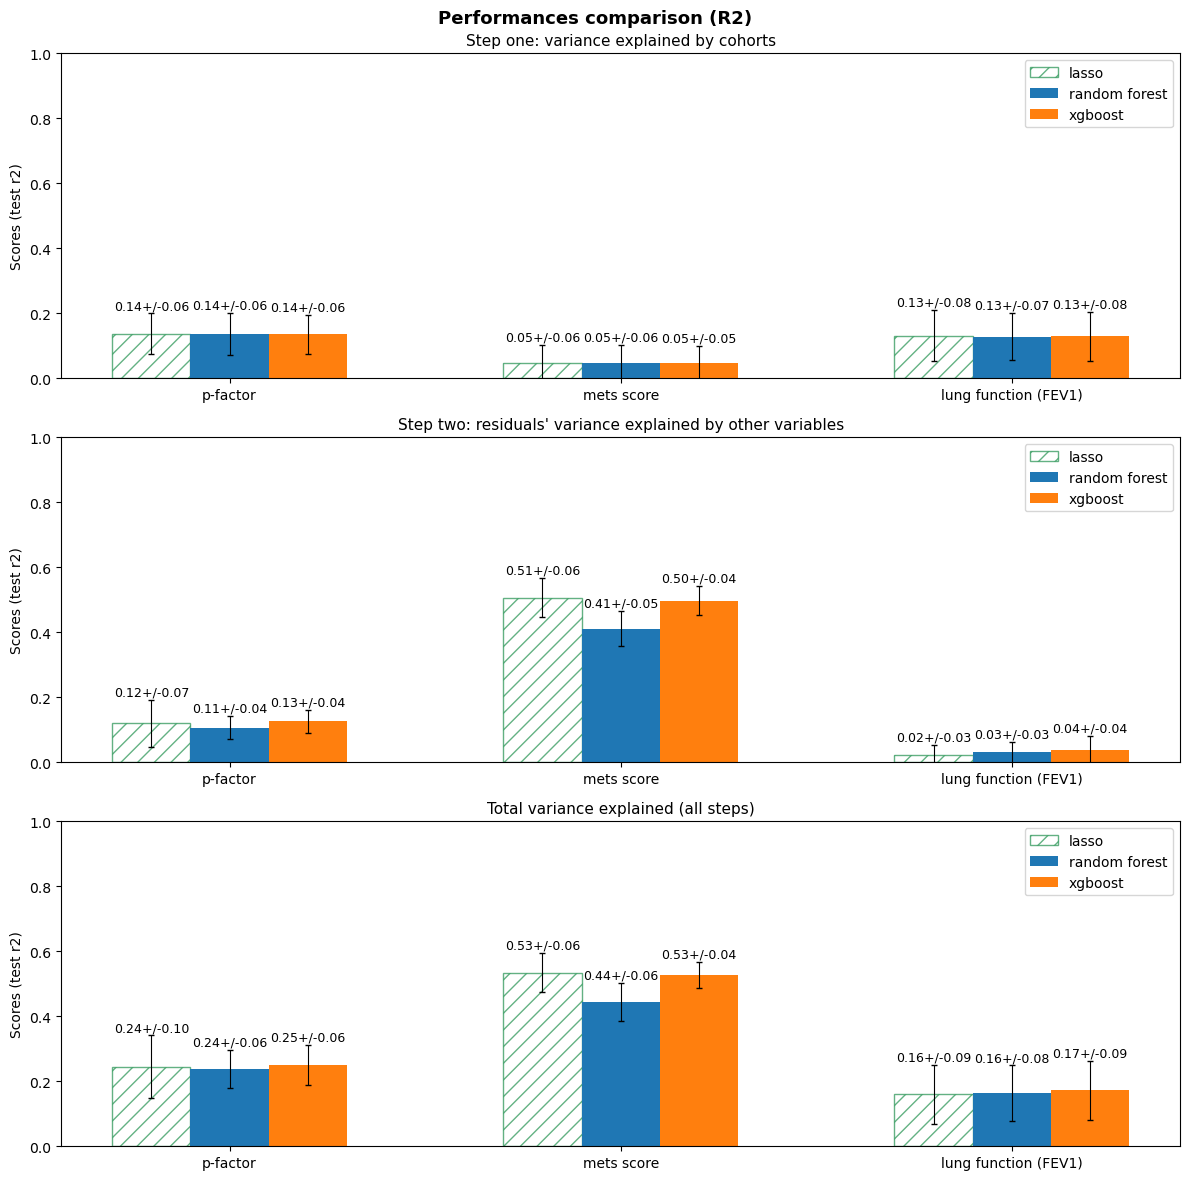

In [8]:
def plot_2s_perf_comparison2(r2=True):
    # lasso_labels=["step2_lasso_cv_all_test_r2"],
    # rf_labels = ["step2_randomforestregressor_cv_all_test_r2", "step2_randomforestregressor_cv_fs_test_r2"],
    # xgb_labels= ["step2_xgbregressor_cv_all_test_r2", "step2_xgbregressor_cv_fs_test_r2"],
    
    analyse_type='2STEPS'
    is_test=True
    lasso_labels = ['step1_linearregression_cv_test_R2', 'step2_lasso_cv_all_test_r2', 'final_lasso_cv_all_test_r2']
    rf_labels = ['step1_randomforestregressor_cv_test_r2', 'step2_randomforestregressor_cv_all_test_r2', 'final_randomforestregressor_cv_all_test_r2']
    xgb_labels = ['step1_xgbregressor_cv_test_r2', 'step2_xgbregressor_cv_all_test_r2', 'final_xgbregressor_cv_all_test_r2']
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle("Performances comparison (R2)", fontsize=13, fontweight='bold')
    plot_perf_comparison_ax2(ax1, lasso_label=lasso_labels[0],
                            rf_labels=[rf_labels[0]],
                            xgb_labels=[xgb_labels[0]],
                            analyse_type='COVARIATES',
                            is_test=True)
    ax1.set_title(f"Step one: variance explained by cohorts", fontsize=11)
    plot_perf_comparison_ax2(ax2, lasso_label=lasso_labels[1],
                            rf_labels=[rf_labels[1]],
                            xgb_labels= [xgb_labels[1]],
                            analyse_type='2STEPS',
                            is_test=True, set_bugged_text=True)
    ax2.set_title(f"Step two: residuals' variance explained by other variables", fontsize=11)
    plot_perf_comparison_ax2(ax3, lasso_label=lasso_labels[2],
                            rf_labels=[rf_labels[2]],
                            xgb_labels=[xgb_labels[2]],
                            analyse_type='2STEPS',
                            is_test=True)
    ax3.set_title(f"Total variance explained (all steps)", fontsize=11)
    fig.tight_layout()
    fig.savefig('./../../data/results/images/perfs.png')
    plt.show()

plot_2s_perf_comparison2()

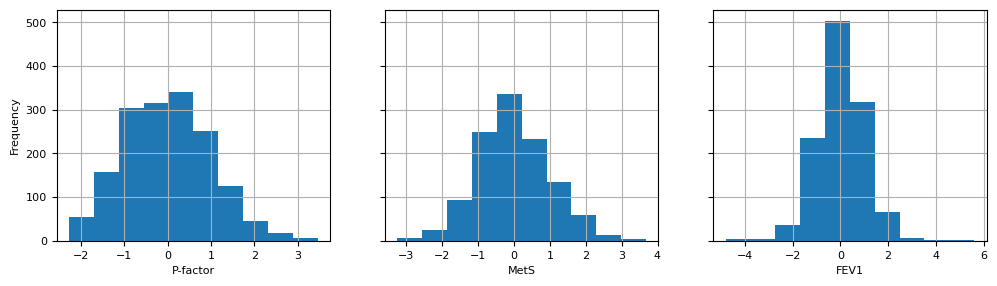

In [9]:
targets = pd.read_csv('./../../data/outcomes/outcomes.csv', usecols=['GPF', 'hs_metsscore', 'FEV1_PP'])
transformed_targets = targets.copy()
transformed_targets[['GPF', 'hs_metsscore']] = np.sqrt(targets[['GPF', 'hs_metsscore']] + np.abs(np.min(targets[['GPF', 'hs_metsscore']], axis=0)))
transformed_targets['hs_metsscore'][(transformed_targets['hs_metsscore'] < 1)] = 1 # erase outlier

# standardize target
transformed_targets = (transformed_targets - transformed_targets.mean())/transformed_targets.std()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), sharey=True)
# fig.suptitle('Outcomes distributions')

transformed_targets['GPF'].hist(ax=ax1)
ax1.set_ylabel("Frequency", fontsize=8)
ax1.set_xlabel("P-factor", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

transformed_targets['hs_metsscore'].hist(ax=ax2)
ax2.set_xlabel("MetS", fontsize=8)
ax2.tick_params(axis='x', which='major', labelsize=8)

transformed_targets['FEV1_PP'].hist(ax=ax3)
ax3.set_xlabel("FEV1", fontsize=8)
ax3.tick_params(axis='x', which='major', labelsize=8)

fig.savefig('./../../data/results/images/outcomes_distributions.png')

# print(transformed_targets.min())
# print(transformed_targets.max())

**Feature importance aggregated results**

In [329]:
# 2 steps adjusted fi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance_ax(ax, importances, std, labs, kmost, title, textsize=20, annotations_size=14):
    indices = np.argsort(importances)[::-1]
    ind = [x for x in range(kmost)]
    # print(indices)
    # print(indices[0:kmost], importances)
    x = list(importances[indices[0:kmost]][::-1])
    xerr = list(std[indices[0:kmost]][::-1])
    labels = [key for key in labs[indices[0:kmost]]][::-1]
    # print(labels)
    
    ax.set_title(title, fontsize=textsize)
    bars = ax.barh(ind, x, xerr=xerr, color='#419197', align="center", error_kw={"elinewidth": 1.5, "capsize": 3, "capthick": 2})
    # sns.barplot(
    #     x=ind, y=x, orient="h", capsize=.4, errcolor=".5", ax=ax,
    #     linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0)
    # )
    ax.set_yticks(ticks=range(kmost))
    ax.set_yticklabels(labels, fontsize=textsize-2)
    ax.set_ylim([-1, kmost])
    ax.set_xlabel("mean(|SHAP values|)", fontsize=textsize-2)
    ax.tick_params(axis="x", labelsize=textsize-4)
    for k, y in enumerate(ind):
        if x[k] < 0.01 and xerr[k] < 0.005:
            ax.annotate("{0:.2f}".format(x[k]), (x[k] + xerr[k], y), textcoords='offset points',
                        xytext=(0, 3), ha='center', va='bottom', fontsize=annotations_size)
        else:
            ax.annotate("{0:.2f} +/- {1:.2f}".format(x[k], xerr[k]), (x[k] + xerr[k], y), textcoords='offset points',
                        xytext=(0, 3), ha='center', va='bottom', fontsize=annotations_size)
    return indices, bars

def colour_bars(feature_names, bars, mapping):
    # colour each bar according to their type
    vartype_x_labels = mapping(feature_names, category='vartype')
    # print(vartype_x_labels)
    
    # print(bars.patches)
    # print(feature_names)
    # color_mapping = {'Metabolites/Proteins (child)': '#12486B', 'Exposures (mother and child)': '#78D6C6', 'Clinical factors (parents and child)': '#419197', 'Covariates (mother and child)': '#F5FCCD'}
    color_mapping = {'Metabolites/Proteins': '#12486B', 'Exposures': '#78D6C6', 'Clinical factors': '#419197', 'Covariates': '#F5FCCD'}
    for i, patche in enumerate(bars.patches):
        for j, key in enumerate(vartype_x_labels.keys()):
            if feature_names[i] in vartype_x_labels[key]:
                patche.set_facecolor(color_mapping[key])

,raw,exposure,GPF mean feature importance,GPF mean std,hs_metsscore mean feature importance,hs_metsscore mean std,FEV1_PP mean feature importance,FEV1_PP mean std
0,PSS_4_Score,Maternal stress,0.160336,0.009978,0.000313,0.000690,0.000000,0.000000
1,hs_noi_othchild,Noise disturbance (other children),0.045200,0.011842,0.000147,0.000441,0.000000,0.000000
2,hs_zbmi_who,zBMI (child),0.040462,0.009477,0.000000,0.000000,0.059365,0.007252
3,hs_noi_neigh,Noise disturbance (neighbours),0.036108,0.006358,0.000193,0.000432,0.000000,0.000000
4,Tyrosine,Tyrosine,0.024733,0.009810,0.005429,0.003663,0.002126,0.001985


,family,GPF mean feature importance,GPF mean std,hs_metsscore mean feature importance,hs_metsscore mean std,FEV1_PP mean feature importance,FEV1_PP mean std
0,Parental clinical factors,0.162221,0.010947,0.013282,0.003968,0.000571,0.001714
1,Noise,0.070375,0.008611,0.008731,0.003817,0.007117,0.002891
2,Lifestyle,0.056922,0.006483,0.045036,0.005727,0.028098,0.005672
3,Clinical factors,0.047560,0.008458,0.000744,0.000961,0.061466,0.008082
4,Urine metabolome,0.035235,0.006492,0.070876,0.005975,0.063095,0.008286



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(25,) (25,) (25,)


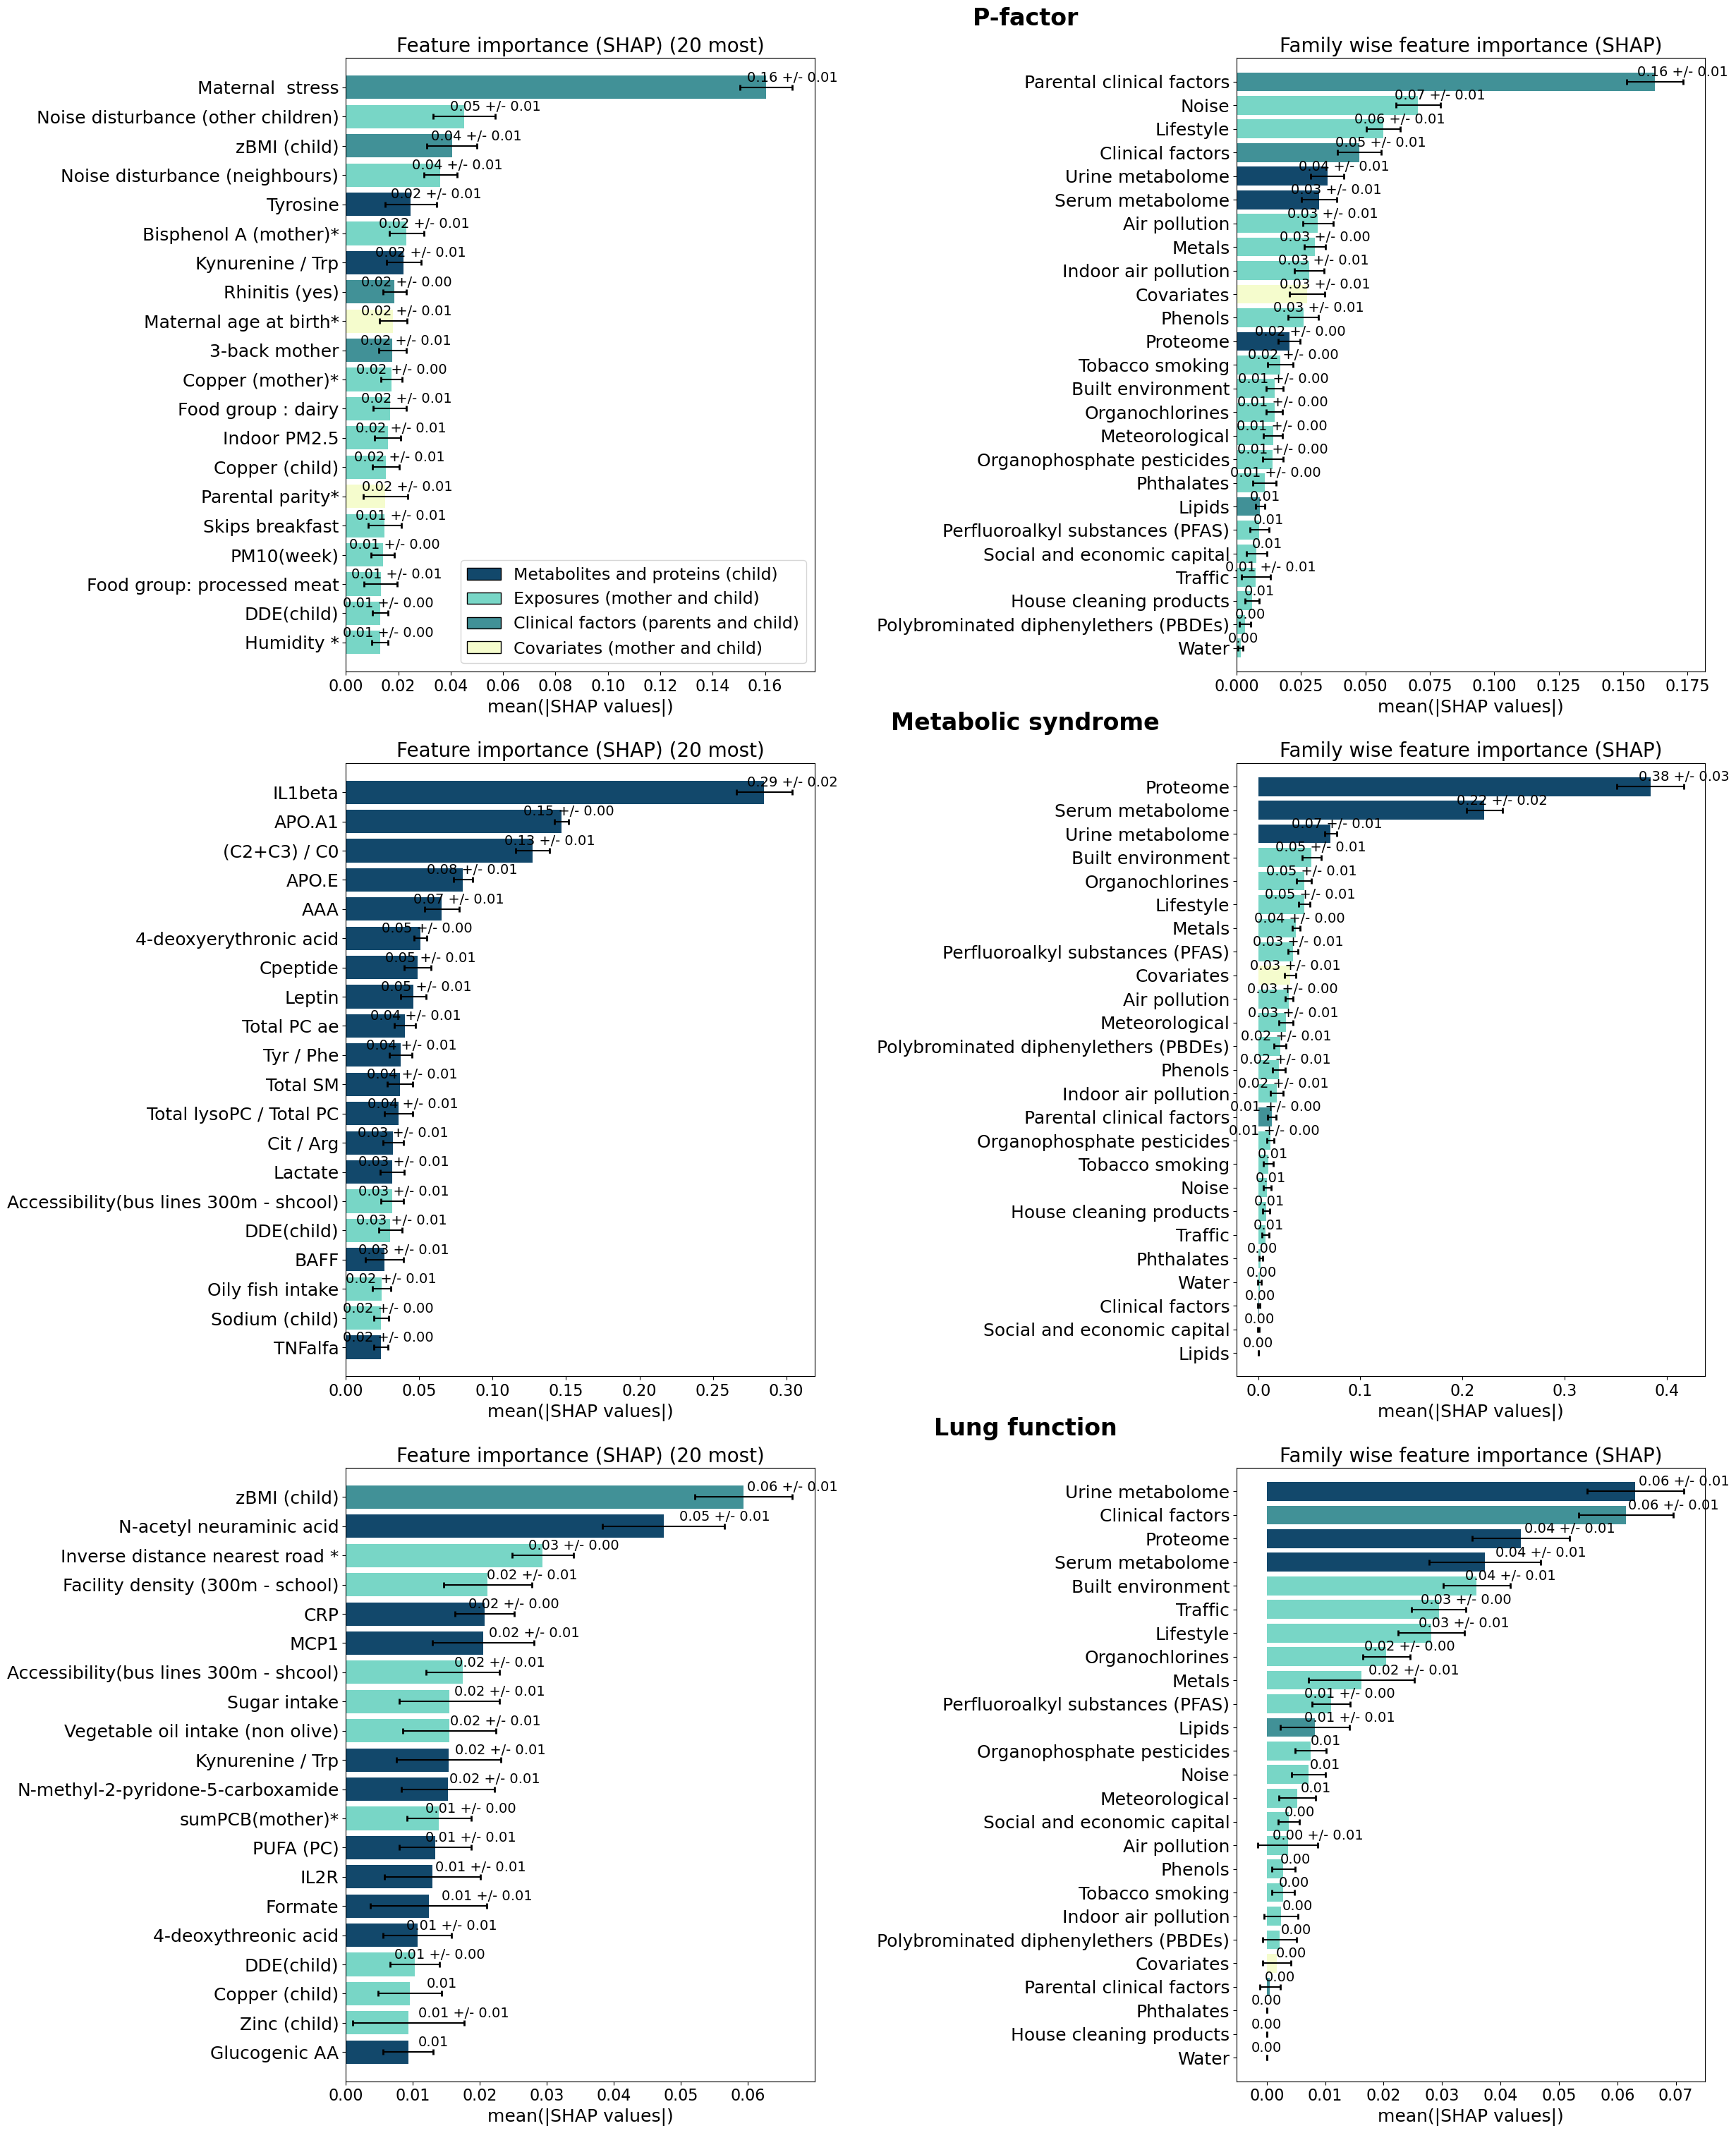

In [333]:
from utils import compute_category_x_variable_names_mapping, compute_vartypes_x_families_mapping, get_oh_x_orig_mapping
from matplotlib.patches import Rectangle

fi_results_2s = pd.read_excel("./../../data/results/2steps_fi.xlsx")
display(fi_results_2s.head(5))
fam_fi_results_2s = pd.read_excel("./../../data/results/family_2steps_fi.xlsx")
display(fam_fi_results_2s.head(5))
pfac_fi, pfac_std = fi_results_2s["GPF mean feature importance"], fi_results_2s["GPF mean std"]
mets_fi, mets_std = fi_results_2s["hs_metsscore mean feature importance"], fi_results_2s["hs_metsscore mean std"]
resp_fi, resp_std = fi_results_2s["FEV1_PP mean feature importance"], fi_results_2s["FEV1_PP mean std"]
labels = fi_results_2s["exposure"]

# add * to pregnancy labels
codebook = pd.read_excel('./../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'name_for_table', 'period']].set_index('variable_name')
raw_labels = fi_results_2s['raw']
mapping = get_oh_x_orig_mapping(raw_labels)
for i in range(0, len(labels)):
    try:
        idx = codebook.loc[raw_labels[i]]
    except KeyError:
        idx = codebook.loc[mapping[raw_labels[i]]]
    if idx['period'] == 'Pregnancy':
        labels[i] = labels[i] + '*'
        # print("DEBUG: added * to:", labels[i])

pfac_fam_fi, pfac_fam_std = fam_fi_results_2s["GPF mean feature importance"], fam_fi_results_2s["GPF mean std"]
mets_fam_fi, mets_fam_std = fam_fi_results_2s["hs_metsscore mean feature importance"], fam_fi_results_2s["hs_metsscore mean std"]
resp_fam_fi, resp_fam_std = fam_fi_results_2s["FEV1_PP mean feature importance"], fam_fi_results_2s["FEV1_PP mean std"]
families = fam_fi_results_2s['family']

# add * to pregnancy family labels
# codebook = pd.read_excel('./../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'family', 'period', 'selected']].set_index('variable_name')
# preg_families = list(set(codebook['family'].loc[(codebook['period'] == 'Pregnancy') & (codebook['selected'] == 1)]))
# for i in range(0, len(families)):
#     if families[i] in preg_families:
#         families[i] += "*"
#         # print("DEBUG: added * to:", families[i])

#using subplots
def create_subtitle(fig: plt.Figure, grid, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=24)
    row.set_frame_on(False)
    row.axis('off')
rows = 3
cols = 2
fig, (axs1, axs2, axs3) = plt.subplots(rows, cols, figsize=(20, 30))
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'P-factor')
create_subtitle(fig, grid[1, ::], 'Metabolic syndrome')
create_subtitle(fig, grid[2, ::], 'Lung function')
fig.tight_layout(h_pad=2, w_pad=40)
# fig.set_facecolor('w')
print(mets_fam_fi.shape, mets_fam_std.shape, families.shape)
indices = np.argsort(mets_fam_fi)[::-1]
# print(mets_fam_fi)
# print(indices)
# print(list(mets_fam_fi[indices[0:28]]))
kmost = 20
standard_title = f"Feature importance (SHAP) ({kmost} most)"
family_title = "Family wise feature importance (SHAP)"
indices, bars = plot_feature_importance_ax(axs1[0], pfac_fi, pfac_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)
# Add legend
handles = [Rectangle((0,0), 1, 1,color=c, ec="k") for c in ['#12486B', '#78D6C6', '#419197', '#F5FCCD']]
l= ['Metabolites and proteins (child)', 'Exposures (mother and child)', 'Clinical factors (parents and child)', 'Covariates (mother and child)']
axs1[0].legend(handles, l, fontsize=17)

indices, bars = plot_feature_importance_ax(axs1[1], pfac_fam_fi, pfac_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

indices, bars = plot_feature_importance_ax(axs2[0], mets_fi, mets_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)

indices, bars = plot_feature_importance_ax(axs2[1], mets_fam_fi, mets_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

indices, bars = plot_feature_importance_ax(axs3[0], resp_fi, resp_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)

indices, bars = plot_feature_importance_ax(axs3[1], resp_fam_fi, resp_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

plt.savefig('./../../data/results/feature_importances.png', bbox_inches="tight")
plt.show()

In [327]:
vt_fi_results_2s = pd.read_excel("./../../data/results/vartype_2steps_fi.xlsx")
display(vt_fi_results_2s.head(5))
pfac_vt_fi, pfac_vt_std = vt_fi_results_2s["GPF mean feature importance"], vt_fi_results_2s["GPF mean std"]
mets_vt_fi, mets_vt_std = vt_fi_results_2s["hs_metsscore mean feature importance"], vt_fi_results_2s["hs_metsscore mean std"]
resp_vt_fi, resp_vt_std = vt_fi_results_2s["FEV1_PP mean feature importance"], vt_fi_results_2s["FEV1_PP mean std"]
vartypes = vt_fi_results_2s['family']


,family,GPF mean feature importance,GPF mean std,hs_metsscore mean feature importance,hs_metsscore mean std,FEV1_PP mean feature importance,FEV1_PP mean std
0,Exposures (mother and child),0.135956,0.012819,0.144950,0.012360,0.078055,0.009557
1,Metabolites/Proteins (child),0.055767,0.004026,0.496621,0.036476,0.098796,0.011564
2,Covariates (mother and child),0.027463,0.006880,0.031208,0.005474,0.001735,0.002398
3,Clinical factors (parents and child),0.175023,0.012196,0.013420,0.003975,0.061310,0.009162


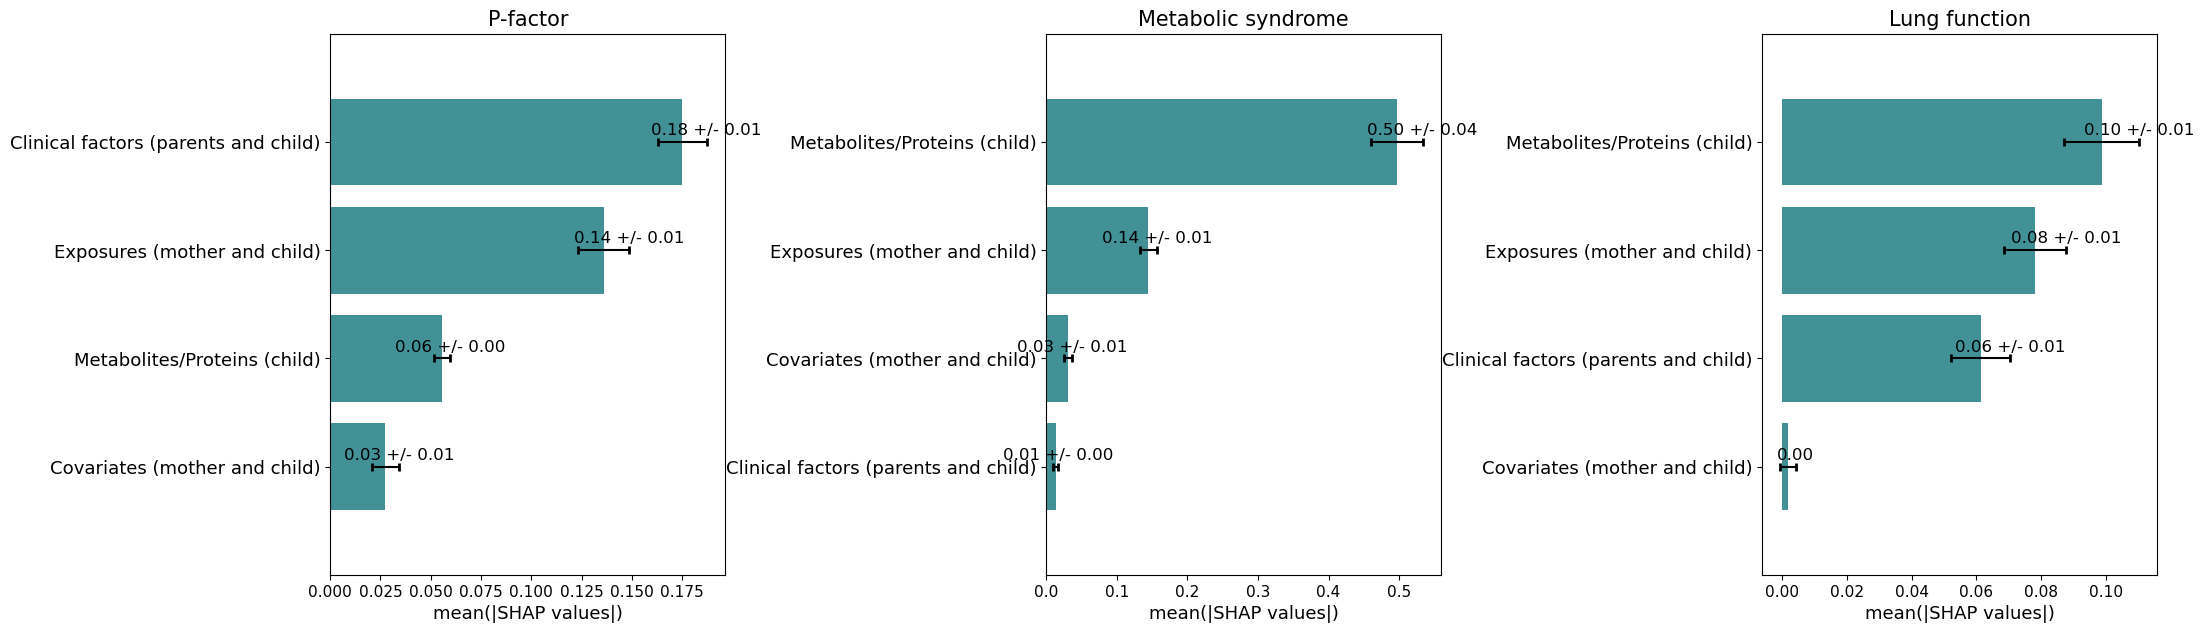

In [328]:
rows = 1
cols = 3
fig, (axs1, axs2, axs3) = plt.subplots(rows, cols, figsize=(19, 6))
fig.tight_layout(h_pad=0, w_pad=20)
plot_feature_importance_ax(axs1, pfac_vt_fi, pfac_vt_std, vartypes, kmost=len(vartypes), title="P-factor", textsize=15, annotations_size=12)
plot_feature_importance_ax(axs2, mets_vt_fi, mets_vt_std, vartypes, kmost=len(vartypes), title="Metabolic syndrome", textsize=15, annotations_size=12)
plot_feature_importance_ax(axs3, resp_vt_fi, resp_vt_std, vartypes, kmost=len(vartypes), title="Lung function", textsize=15, annotations_size=12)
plt.savefig('./../../data/results/var_type_feature_importances.png', bbox_inches="tight")
plt.show()

In [334]:
per_fi_results_2s = pd.read_excel("./../../data/results/period_2steps_fi.xlsx").set_index('family')
display(per_fi_results_2s.head(5))
pfac_per_fi, pfac_per_std = per_fi_results_2s["GPF mean feature importance"], per_fi_results_2s["GPF mean std"]
mets_per_fi, mets_per_std = per_fi_results_2s["hs_metsscore mean feature importance"], per_fi_results_2s["hs_metsscore mean std"]
resp_per_fi, resp_per_std = per_fi_results_2s["FEV1_PP mean feature importance"], per_fi_results_2s["FEV1_PP mean std"]
period = per_fi_results_2s.index

,GPF mean feature importance,GPF mean std,hs_metsscore mean feature importance,hs_metsscore mean std,FEV1_PP mean feature importance,FEV1_PP mean std
family,,,,,,
Postnatal,0.229705,0.008518,0.509278,0.025229,0.133541,0.007376
Pregnancy,0.058251,0.005532,0.056926,0.004859,0.044006,0.005381


In [335]:
print("Ratio pfactor:", pfac_per_fi.loc['Postnatal']/ pfac_per_fi.loc['Pregnancy'])
print("Ratio MetS:", mets_per_fi.loc['Postnatal']/ mets_per_fi.loc['Pregnancy'])
print("Ratio Lung function:", resp_per_fi.loc['Postnatal']/ resp_per_fi.loc['Pregnancy'])

Ratio pfactor: 3.9433677557995
Ratio MetS: 8.946384820025587
Ratio Lung function: 3.0346444591103636


,raw,exposure,hs_metsscore mean feature importance,hs_metsscore mean std,GPF mean feature importance,GPF mean std,FEV1_PP mean feature importance,FEV1_PP mean std
0,IL1beta,IL1beta,0.340184,0.028284,0.022623,0.011547,0.000000,0.000000
1,APO.A1,APO.A1,0.209556,0.013293,0.022673,0.005750,0.001017,0.002319
2,APO.E,APO.E,0.143930,0.010668,0.000000,0.000000,0.000000,0.000000
3,AAA,AAA,0.117391,0.013365,0.000000,0.000000,0.000000,0.000000
4,e3_sex,Child sex,0.113948,0.005956,0.046617,0.006439,0.000290,0.000870


,family,hs_metsscore mean feature importance,hs_metsscore mean std,GPF mean feature importance,GPF mean std,FEV1_PP mean feature importance,FEV1_PP mean std
0,Proteome,0.429393,0.033423,0.044260,0.008887,0.054442,0.007145
1,Serum metabolome,0.249707,0.027765,0.029364,0.007216,0.018383,0.005971
2,Covariates,0.125789,0.008725,0.066192,0.008360,0.014317,0.005994
3,Lifestyle,0.108441,0.008928,0.096014,0.010728,0.045857,0.007861
4,Metals,0.098329,0.011927,0.034422,0.008872,0.004709,0.002312



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(25,) (25,) (25,)


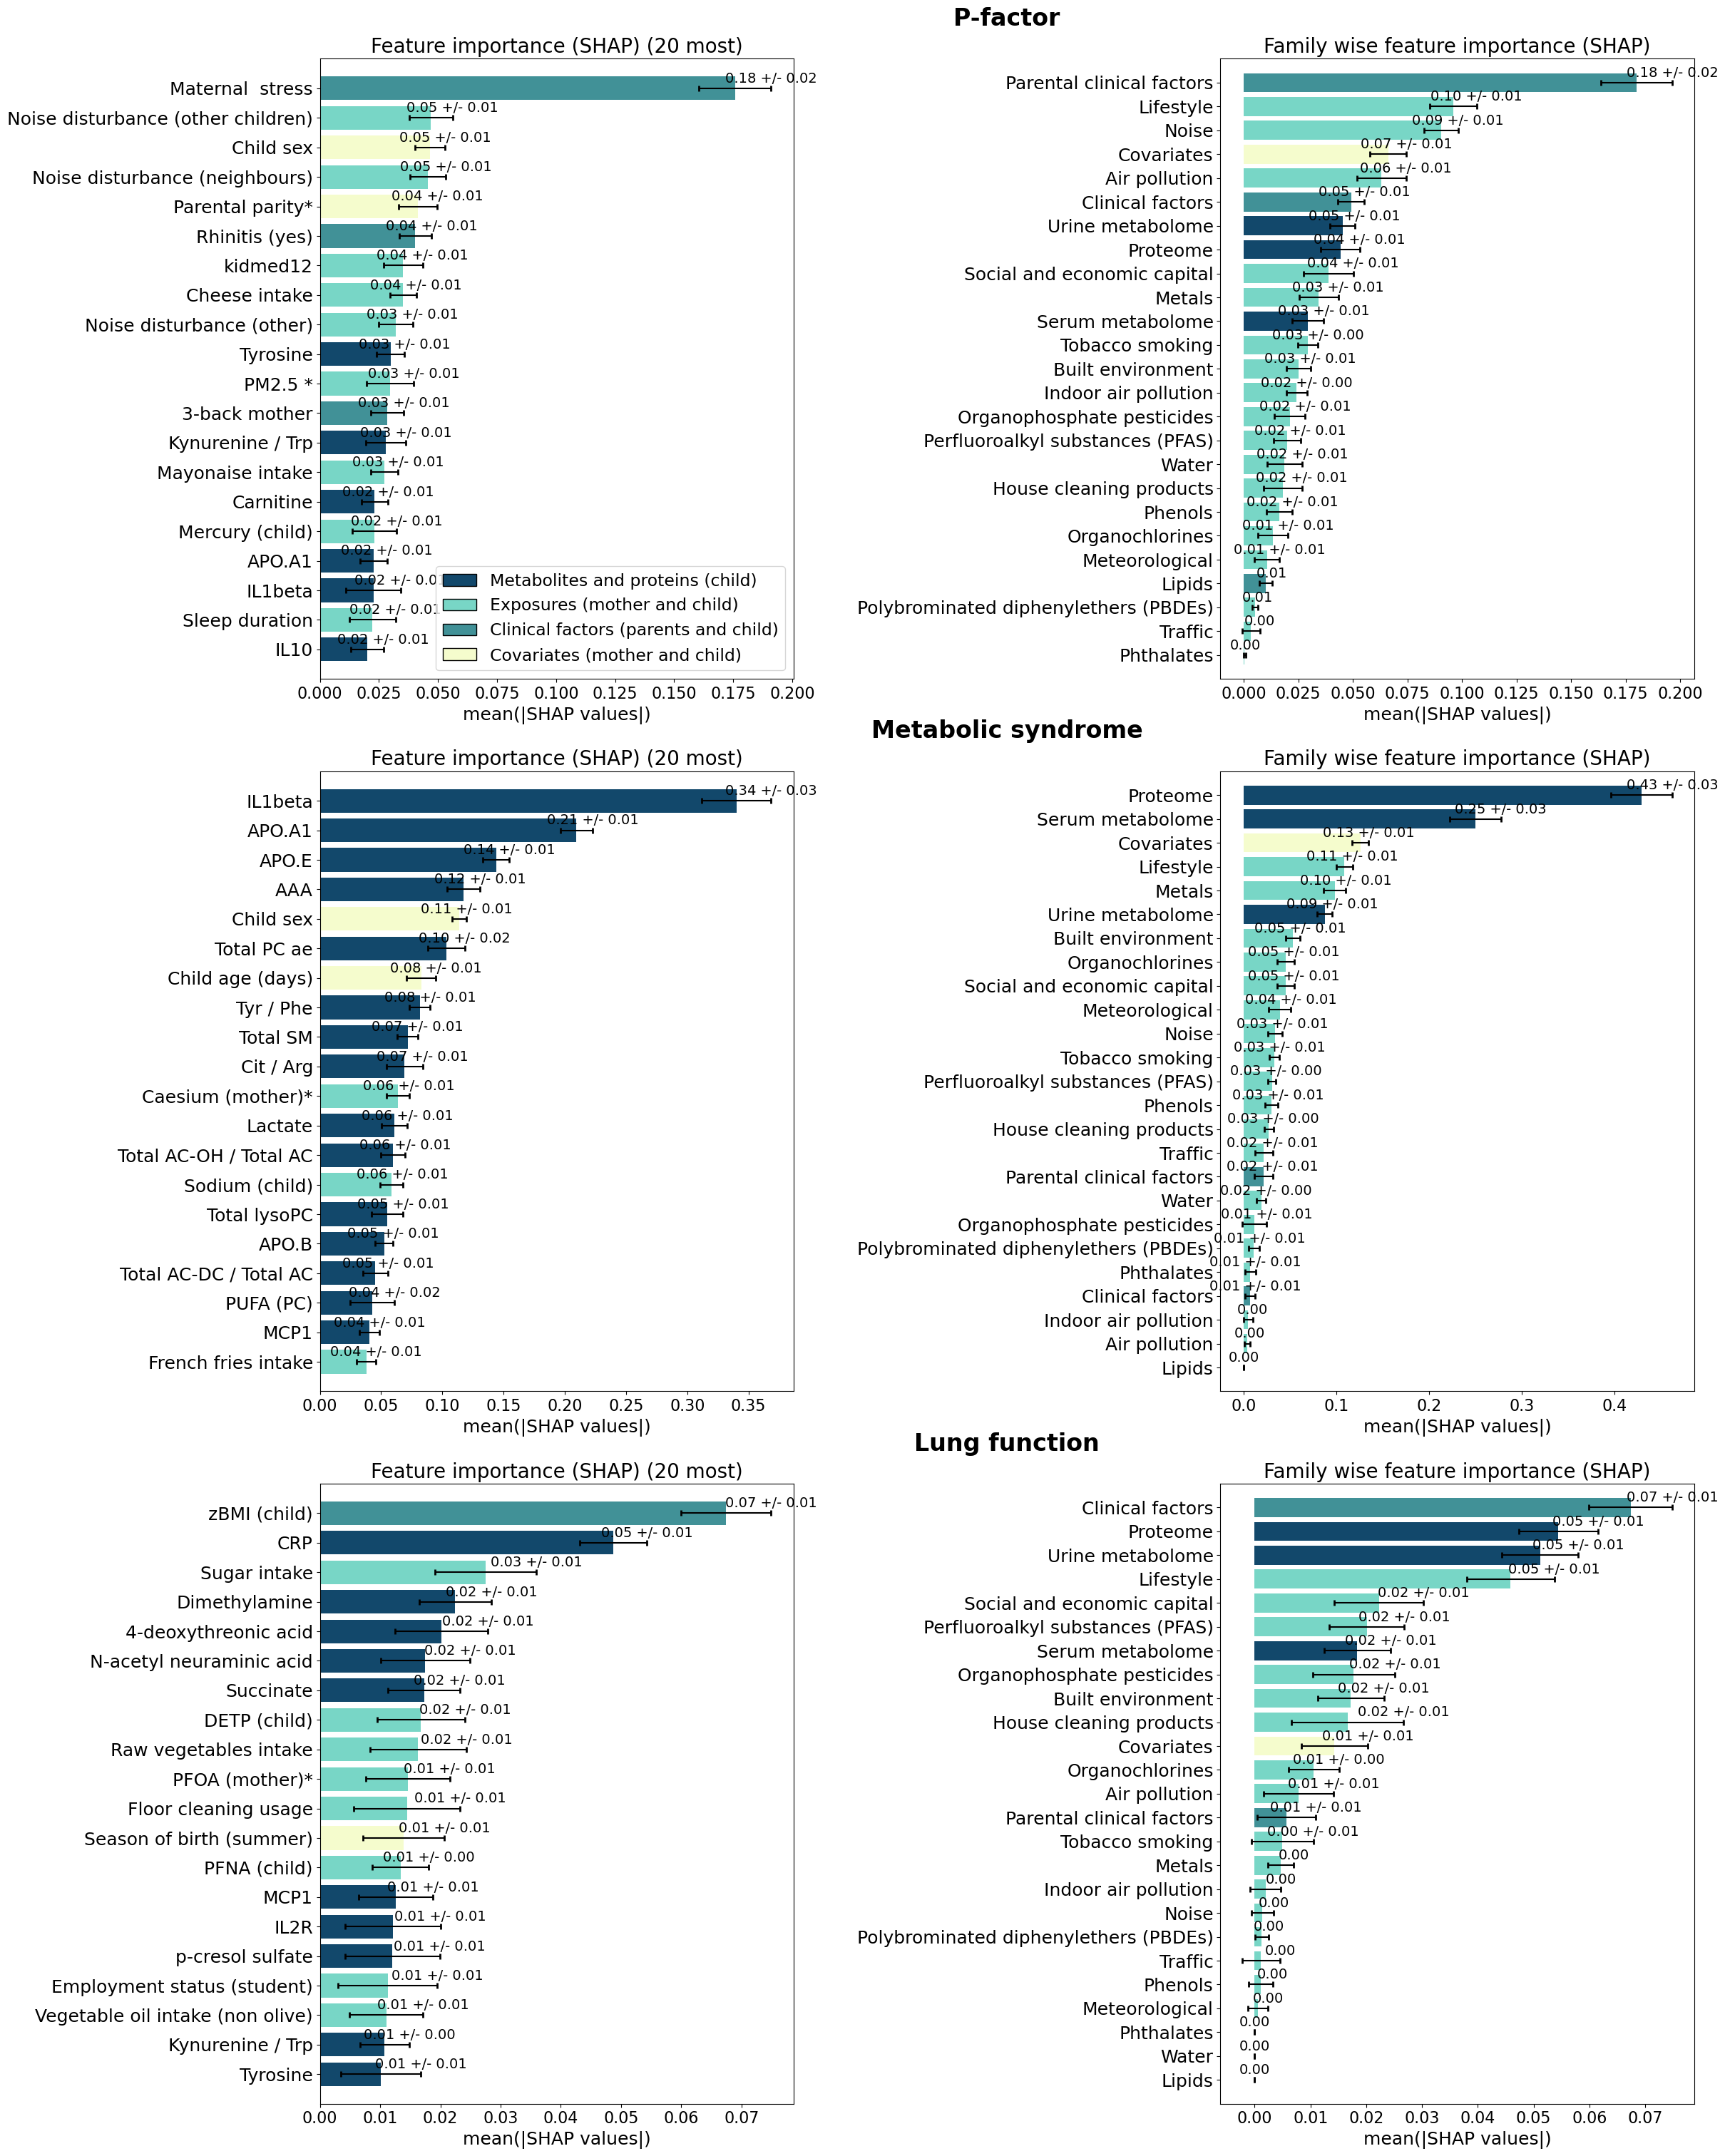

In [340]:
# LASSO feature importances
from utils import compute_category_x_variable_names_mapping, compute_vartypes_x_families_mapping, get_oh_x_orig_mapping
from matplotlib.patches import Rectangle

fi_results_2s = pd.read_excel("./../../data/results/2steps_fi_lasso.xlsx")
display(fi_results_2s.head(5))
fam_fi_results_2s = pd.read_excel("./../../data/results/family_2steps_fi_lasso.xlsx")
display(fam_fi_results_2s.head(5))
pfac_fi, pfac_std = fi_results_2s["GPF mean feature importance"], fi_results_2s["GPF mean std"]
mets_fi, mets_std = fi_results_2s["hs_metsscore mean feature importance"], fi_results_2s["hs_metsscore mean std"]
resp_fi, resp_std = fi_results_2s["FEV1_PP mean feature importance"], fi_results_2s["FEV1_PP mean std"]
labels = fi_results_2s["exposure"]

# add * to pregnancy labels
codebook = pd.read_excel('./../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'name_for_table', 'period']].set_index('variable_name')
raw_labels = fi_results_2s['raw']
mapping = get_oh_x_orig_mapping(raw_labels)
for i in range(0, len(labels)):
    try:
        idx = codebook.loc[raw_labels[i]]
    except KeyError:
        idx = codebook.loc[mapping[raw_labels[i]]]
    if idx['period'] == 'Pregnancy':
        labels[i] = labels[i] + '*'
        # print("DEBUG: added * to:", labels[i])

pfac_fam_fi, pfac_fam_std = fam_fi_results_2s["GPF mean feature importance"], fam_fi_results_2s["GPF mean std"]
mets_fam_fi, mets_fam_std = fam_fi_results_2s["hs_metsscore mean feature importance"], fam_fi_results_2s["hs_metsscore mean std"]
resp_fam_fi, resp_fam_std = fam_fi_results_2s["FEV1_PP mean feature importance"], fam_fi_results_2s["FEV1_PP mean std"]
families = fam_fi_results_2s['family']

# add * to pregnancy family labels
# codebook = pd.read_excel('./../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'family', 'period', 'selected']].set_index('variable_name')
# preg_families = list(set(codebook['family'].loc[(codebook['period'] == 'Pregnancy') & (codebook['selected'] == 1)]))
# for i in range(0, len(families)):
#     if families[i] in preg_families:
#         families[i] += "*"
#         # print("DEBUG: added * to:", families[i])

#using subplots
def create_subtitle(fig: plt.Figure, grid, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=24)
    row.set_frame_on(False)
    row.axis('off')
rows = 3
cols = 2
fig, (axs1, axs2, axs3) = plt.subplots(rows, cols, figsize=(20, 30))
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'P-factor')
create_subtitle(fig, grid[1, ::], 'Metabolic syndrome')
create_subtitle(fig, grid[2, ::], 'Lung function')
fig.tight_layout(h_pad=2, w_pad=40)
# fig.set_facecolor('w')
print(mets_fam_fi.shape, mets_fam_std.shape, families.shape)
indices = np.argsort(mets_fam_fi)[::-1]
# print(mets_fam_fi)
# print(indices)
# print(list(mets_fam_fi[indices[0:28]]))
kmost = 20
standard_title = f"Feature importance (SHAP) ({kmost} most)"
family_title = "Family wise feature importance (SHAP)"
indices, bars = plot_feature_importance_ax(axs1[0], pfac_fi, pfac_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)
# Add legend
handles = [Rectangle((0,0), 1, 1,color=c, ec="k") for c in ['#12486B', '#78D6C6', '#419197', '#F5FCCD']]
l= ['Metabolites and proteins (child)', 'Exposures (mother and child)', 'Clinical factors (parents and child)', 'Covariates (mother and child)']
axs1[0].legend(handles, l, fontsize=17)

indices, bars = plot_feature_importance_ax(axs1[1], pfac_fam_fi, pfac_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

indices, bars = plot_feature_importance_ax(axs2[0], mets_fi.to_numpy(), mets_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)

indices, bars = plot_feature_importance_ax(axs2[1], mets_fam_fi, mets_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

indices, bars = plot_feature_importance_ax(axs3[0], resp_fi, resp_std, labels, kmost=kmost, title=standard_title)
colour_bars(list(fi_results_2s["raw"][indices[0:kmost]][::-1]), bars, compute_category_x_variable_names_mapping)

indices, bars = plot_feature_importance_ax(axs3[1], resp_fam_fi, resp_fam_std, families, kmost=len(families), title=family_title)
colour_bars(list(fam_fi_results_2s['family'][indices[0:len(bars.patches)]][::-1]), bars, compute_vartypes_x_families_mapping)

plt.savefig('./../../data/results/feature_importances_lasso.png', bbox_inches="tight")
plt.show()